## Settings and Pointers

In [1]:
service_account_path = "creds/google__sa.json"
tracking_sheet_id = "1qBU7Kvuuij2fxbqPxebReKMxWgIBmOIE5Gi4ZuX0j_4"


In [23]:
import pandas as pd

from src.sheets_utils import download_sheet_as_df


contributors_df = download_sheet_as_df(
    service_account_path,
    tracking_sheet_id,
    "Contributors"
)

df = pd.concat(
    [
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_2"
        ),
        download_sheet_as_df(
            service_account_path,
            tracking_sheet_id,
            "Conversations_Batch_3"
        ),
    ],
    ignore_index=True
)

df = df[df["completion_status"] == "Done"].reset_index()
df

,index,task_link,metadata__topic,Team_Type(Internal/External),assigned_to_email,completion_status,modified_question?,duration_mins,completion_date,comments,"is this answer written by you, and not by GPT or any other LLMs directly?",metadata__batch_idx,metadata__problem_type,metadata__target_length,metadata__type
0,0,https://colab.research.google.com/drive/10cwJG...,python_language_and_scripting > functions_and_...,External,lucas.k@turing.com,Done,FALSE,13,12/21/2023,,,v0,query,1,NaN
1,1,https://colab.research.google.com/drive/16dCMc...,unit_testing_methodology > test_driven_develop...,External,ruturaj.m@turing.com,Done,TRUE,15,12/21/2023,,,v0,query,1,NaN
2,2,https://colab.research.google.com/drive/17KaqC...,python_language_and_scripting > decorators,External,ruturaj.m@turing.com,Done,FALSE,10,12/21/2023,,,v0,query,1,NaN
3,3,https://colab.research.google.com/drive/17mMiU...,algorithms > by_topic > bit_manipulation,Internal,daniel.oluwakayode-c@turing.com,Done,FALSE,20,12/20/2023,,,v0,query,1,NaN
4,4,https://colab.research.google.com/drive/18nl4l...,python_language_and_scripting > decorators,External,ruturaj.m@turing.com,Done,FALSE,10,12/21/2023,,,v0,modification,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,637,https://colab.research.google.com/drive/1dWVO-...,python_language_and_scripting > file_handling,NaN,rohit.kumar@turing.com,Done,FALSE,15,12/23/2023,,NaN,NaN,NaN,2+,modification
470,638,https://colab.research.google.com/drive/1Om0cX...,algorithms > by_topic > game_theory,NaN,archit.k@turing.com,Done,FALSE,30,12/25/2023,,NaN,NaN,NaN,2+,query
471,640,https://colab.research.google.com/drive/1QhKUP...,algorithms > by_data_structure > strings,NaN,rohit.kumar@turing.com,Done,FALSE,30,12/23/2023,,NaN,NaN,NaN,2+,modification
472,642,https://colab.research.google.com/drive/1CQSKk...,algorithms > by_topic > sliding_window,NaN,rohit.kumar@turing.com,Done,FALSE,45,12/23/2023,,NaN,NaN,NaN,2+,query


## Calculate number of turns

In [16]:
# Parse Conversations into list of dicts

import io
import threading

import nbformat
from fuzzywuzzy import fuzz

from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload


def get_closest_match(query, choices):
    """
    Get the closest match(es) to a query string from a list of choices.

    :param query: The query string.
    :param choices: A list of strings to match against.
    :param limit: The maximum number of matches to return.
    """
    best_role = None
    best_score = 0
    for choice in choices:
        score = fuzz.ratio(query, choice)
        if score > best_score and score > 25:
            best_score = score
            best_role = choice

    return best_role, best_score


def notebook_parser(notebook):
    """
    Parse a notebook and extract the message objects.

    :param notebook: The notebook object.
    """
    messages = []
    for cell in notebook.cells[2:]:
        if cell["cell_type"] == "markdown":
            markdown_headers = ["**User**", "**Assistant**"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, markdown_headers)
            if score>25:
                message = {
                    "role": role.replace("*", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "markdown"
                }
                messages.append(message)

        elif cell["cell_type"] == "code":
            code_headers = ["# User", "# Assistant"]
            lines = cell["source"].split("\n")
            first_line = lines[0]
            role, score = get_closest_match(first_line, code_headers)
            if score>25:
                message = {
                    "role": role.replace("#", "").strip(),
                    "content": "\n".join(lines[1:]).strip("\n"),
                    "type": "code"
                }
                messages.append(message)
    return messages


def download_and_parse_notebook(service_account_file, file_id):
    # Authenticate with the service account
    credentials = service_account.Credentials.from_service_account_file(
        service_account_file, scopes=['https://www.googleapis.com/auth/drive'])
    service = build('drive', 'v3', credentials=credentials)

    # Request to download the file
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    # Download the file
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print("Download progress: %d%%." % int(status.progress() * 100))

    # Move the buffer's pointer to the beginning
    fh.seek(0)

    # Open the notebook
    notebook = nbformat.read(fh, as_version=4)

    # Parse the notebook
    messages = notebook_parser(notebook)

    # # Extract the first cell
    first_cell = notebook.cells[0]
    lines = first_cell["source"].split("\n")
    metadata = {}
    for line in lines:
        if "**Python Topics**" in line:
            metadata["topic"] = line.split(" - ")[1]
        if "**Type**" in line:
            metadata["type"] = line.split(" - ")[1]
        if "**Target Number of Turns (User + Assistant)**" in line:
            metadata["target_turns"] = line.split(" - ")[1]

    return {
        "id": file_id,
        "metadata": metadata,
        "messages":messages
    }


def threading_processor(service_account_path, file_id, results):
    results.append(download_and_parse_notebook(service_account_path, file_id))


threads = []
parsed_conversations = []
for i in range(df.shape[0]):
    file_id = df["task_link"][i].split("/")[-1]
    thread = threading.Thread(target=threading_processor, args=(service_account_path, file_id, parsed_conversations))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()


Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


Exception in thread Thread-481:
Traceback (most recent call last):
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_7011/2195223806.py", line 115, in threading_processor
  File "/tmp/ipykernel_7011/2195223806.py", line 83, in download_and_parse_notebook
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/http.py", line 780, in next_chunk
    raise HttpError(resp, content, uri=self._uri)
googleapiclient.errors.HttpError: <HttpError 404 when requesting https://www.googleapis.com/drive/v3/files/1lHYB-8JiU67LlaqjvaRuLYUbetxWbnD5%23scrollT

Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


Exception in thread Thread-483:
Traceback (most recent call last):
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/joe96/miniconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_7011/2195223806.py", line 115, in threading_processor
  File "/tmp/ipykernel_7011/2195223806.py", line 83, in download_and_parse_notebook
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/joe96/projects/turing/character.ai/character_tasks/venv/lib/python3.9/site-packages/googleapiclient/http.py", line 780, in next_chunk
    raise HttpError(resp, content, uri=self._uri)
googleapiclient.errors.HttpError: <HttpError 404 when requesting https://www.googleapis.com/drive/v3/files/1rfNQU__74pEdovonm_-u6yrhF0UsAa2C?alt=media

Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.
Download progress: 100%.


## Visualize distribution of dataset
- Top Level Topic
- Number of Turns
- Internal vs Anthropic vs Dedicated
- Daily Trends by Team
- Daily Trends by Turns

In [56]:
from datetime import datetime

def get_number_of_turns(messages):
    count = 0
    for message in messages:
        if message["role"] == "User":
            count += 1
    return count


def standardize_date_format(date):
    """
    Given a date string, standardize the date format to YYYY/MM/DD.
    """
    try:
        # Parse the date string into a datetime object
        standardized_date = datetime.strptime(date, "%Y/%m/%d")
    except ValueError:
        try:
            # Attempt to parse other common formats here
            # Example: MM/DD/YYYY
            standardized_date = datetime.strptime(date, "%m/%d/%Y")
        except ValueError:
            return "Invalid date format"

    # Format the datetime object into the desired string format
    return standardized_date.strftime("%Y/%m/%d")


metadata_only = []
for conversation in parsed_conversations:
    
    # Extract actual number of turns
    conversation["metadata"]["actual_turns"] = get_number_of_turns(conversation["messages"])

    try:
        tracking_record = df[df["task_link"].str.contains(conversation["id"])].iloc[0].to_dict()
    except IndexError:
        print("IndexError for id:", conversation["id"])
        continue

    # Get Author email
    conversation["metadata"]["assigned_to_email"] = tracking_record["assigned_to_email"]

    # Get duration
    conversation["metadata"]["duration_mins"] = tracking_record["duration_mins"]

    # Get Completion Date
    conversation["metadata"]["completion_date"] = standardize_date_format(tracking_record["completion_date"])

    # Get Team
    try:
        conversation["metadata"]["team"] = contributors_df[contributors_df["Email"] == tracking_record["assigned_to_email"]].iloc[0]["Source"]
    except IndexError:
        print("IndexError for email:", tracking_record["assigned_to_email"])
        conversation["metadata"]["team"] = "Unknown"

    metadata_only.append(conversation["metadata"])

IndexError for email: ishwar@turing.com


In [57]:
metadata_only_df = pd.DataFrame(metadata_only)
metadata_only_df

,topic,type,target_turns,actual_turns,assigned_to_email,completion_date,team,duration_mins
0,python_language_and_scripting > decorators,query,1,1,ruturaj.m@turing.com,2023/12/21,Anthropic,10
1,unit_testing_methodology > test_driven_develop...,query,1,1,ruturaj.m@turing.com,2023/12/21,Anthropic,15
2,python_language_and_scripting > functions_and_...,query,1,1,lucas.k@turing.com,2023/12/21,Anthropic,13
3,python_language_and_scripting > decorators,modification,1,1,ruturaj.m@turing.com,2023/12/21,Anthropic,10
4,python_language_and_scripting > data_serializa...,query,1,1,gautam.g@turing.com,2023/12/20,Anthropic,8
...,...,...,...,...,...,...,...,...
467,data_analysis > duplicate_data_identification,query,2+,3,abdullah.i@turing.com,2023/12/23,Vetting,30
468,database > no_sql_database_concepts,modification,2+,3,paulo.c@turing.com,2023/12/25,Vetting,35
469,python_language_and_scripting > functions_and_...,query,1,1,souza.m@turing.com,2023/12/23,Anthropic,10
470,ml_principles > train_test_split,query,2+,2,toh.y@turing.com,2023/12/26,Anthropic,15


In [38]:
%pip install matplotlib seaborn

  Using cached matplotlib-3.8.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)
  Using cached Pillow-10.1.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.6 MB)
  Using cached kiwisolver-1.4.5-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
  Using cached importlib_resources-6.1.1-py3-none-any.whl (33 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 5.2 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/joe96/projects/turing/character.ai/character_tasks/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


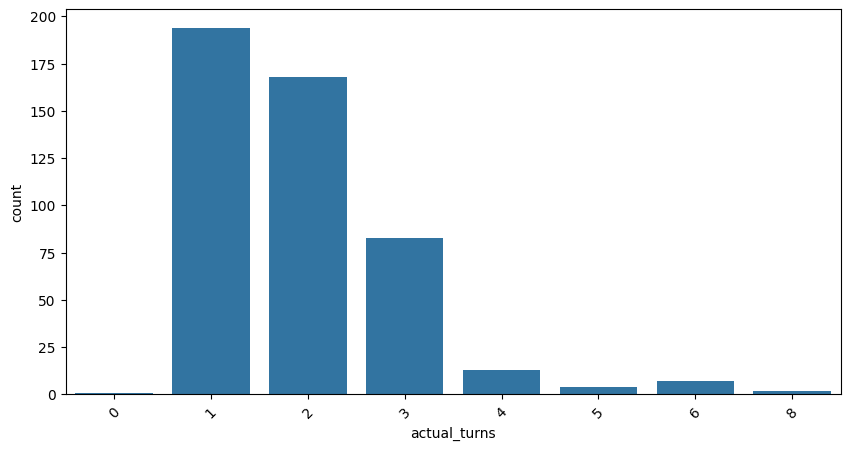

In [39]:
# Visualize Top level topic
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="actual_turns")
plt.xticks(rotation=45)
plt.show()



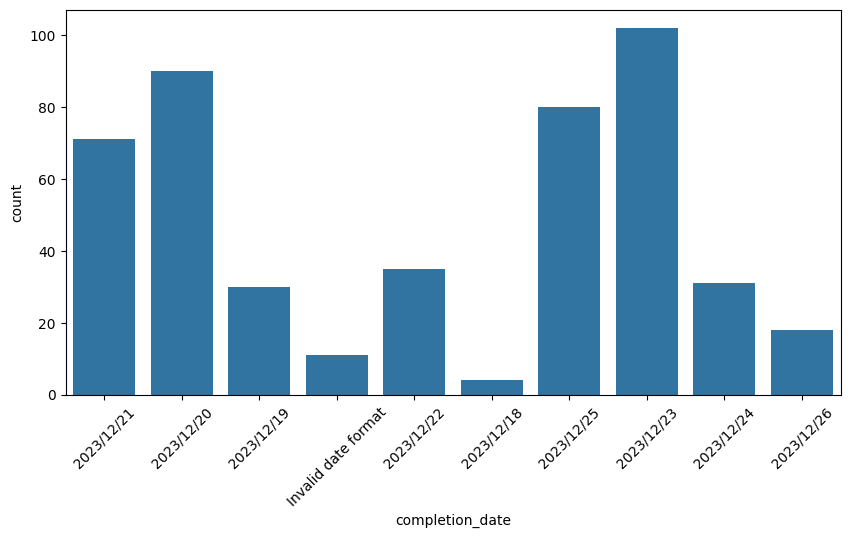

In [40]:
# Visualize Trend over time
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="completion_date")
plt.xticks(rotation=45)
plt.show()

- Top Level Topic
- Number of Turns
- Internal vs Anthropic vs Dedicated
- Daily Trends by Team
- Daily Trends by Turns

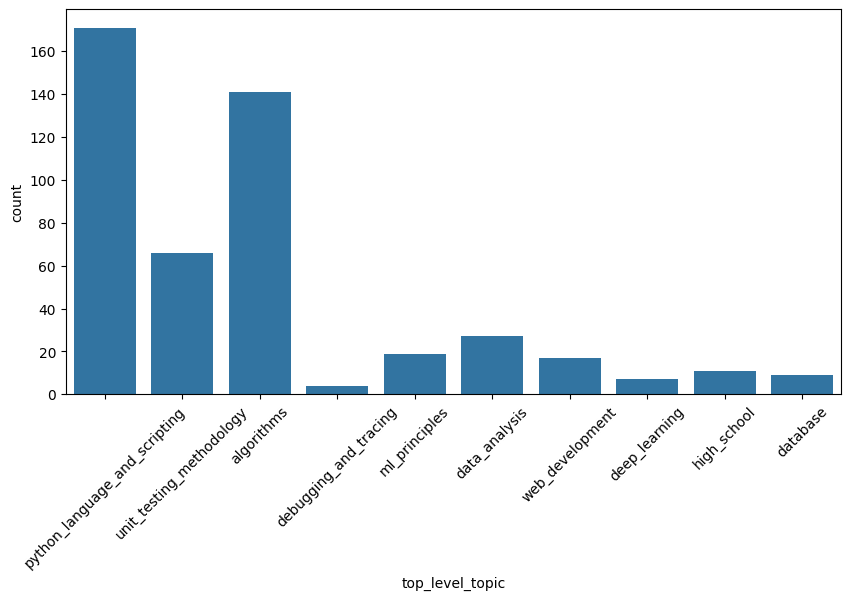

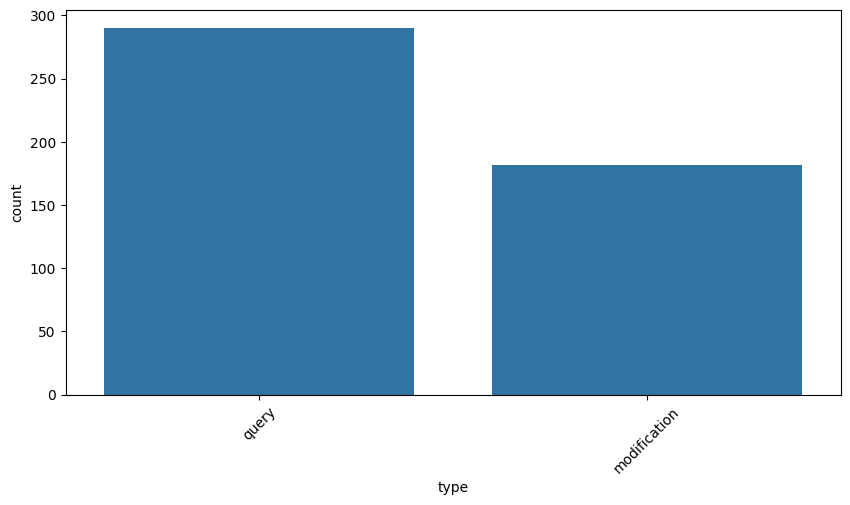

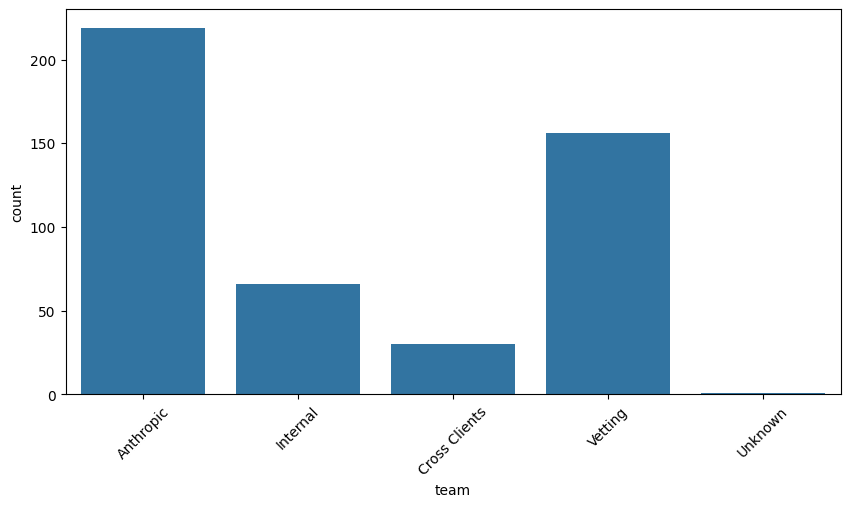

In [49]:
metadata_only_df["top_level_topic"] = metadata_only_df["topic"].apply(lambda x: x.split(" > ")[0])
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="top_level_topic")
plt.xticks(rotation=45)

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="type")
plt.xticks(rotation=45)

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="team")
plt.xticks(rotation=45)

plt.show()

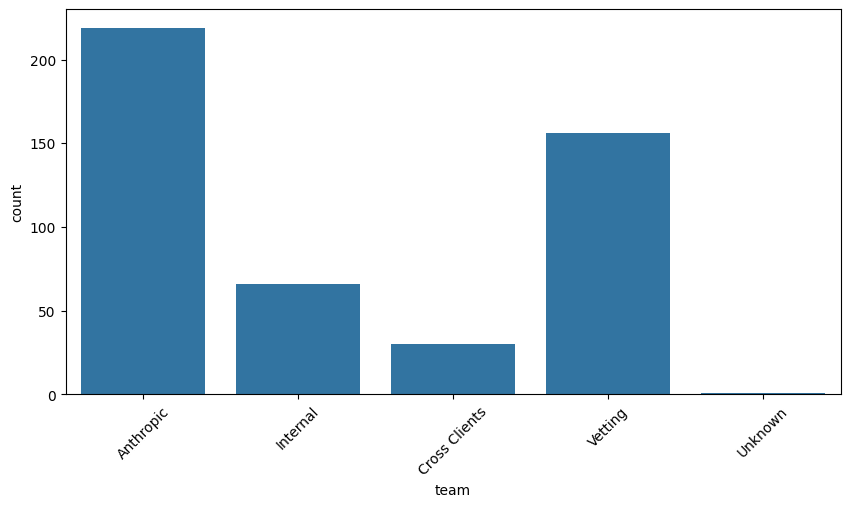

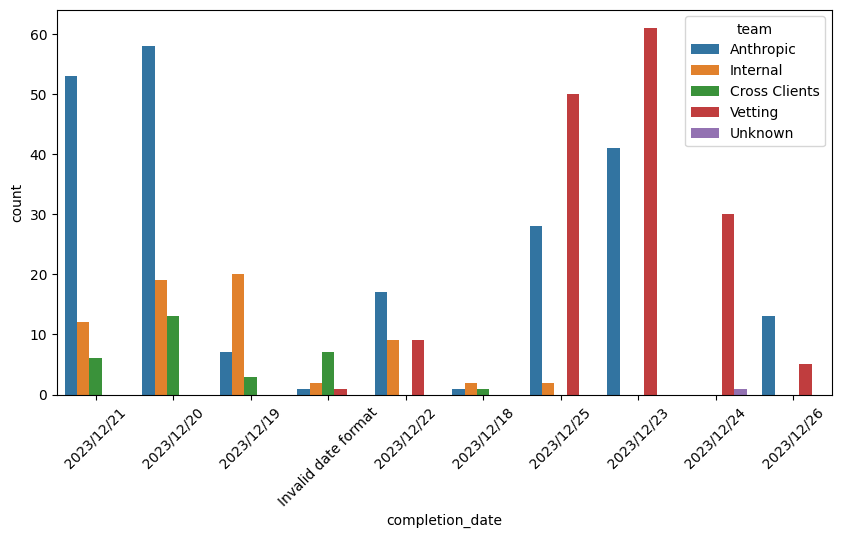

In [48]:
# Breakdown by team (2 subplots; 1 for totals, 1 for trendline by completion_date)
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="team")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_only_df, x="completion_date", hue="team")
plt.xticks(rotation=45)
plt.show()

## Analyze avg time by trainer (Vetting)

In [82]:
# Process the duration_mins column to make into int

def process_duration_mins(duration_mins):
    if duration_mins == "":
        return 0
    elif isinstance(duration_mins, int):
        return duration_mins
    else:
        return int(duration_mins.split(" ")[0])
    
metadata_only_df["duration_mins"] = metadata_only_df["duration_mins"].apply(process_duration_mins)

trainer_avg_duration = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"duration_mins": "mean"}).reset_index()
trainer_avg_duration = trainer_avg_duration.sort_values("duration_mins", ascending=True)
trainer_avg_duration

,assigned_to_email,duration_mins
10,marcel.s@turing.com,22.500000
5,elsadek.a@turing.com,24.250000
7,gedeon.a@turing.com,25.000000
3,armas.j@turing.com,26.250000
6,freitas.g@turing.com,26.250000
11,marcus.a@turing.com,27.250000
2,archit.k@turing.com,30.000000
13,rohit.kumar@turing.com,30.000000
12,paulo.c@turing.com,32.307692
4,caram.v@turing.com,32.500000


## Average turns per trainer

In [84]:
trainer_avg_turn_count = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"actual_turns": "mean", "topic": "count"}).reset_index()
trainer_avg_turn_count = trainer_avg_turn_count.rename(columns={"topic": "total_conversations"})
trainer_avg_turn_count = trainer_avg_turn_count.sort_values("actual_turns", ascending=False)
trainer_avg_turn_count

,assigned_to_email,actual_turns,total_conversations
9,kishore.g@turing.com,6.250000,8
7,gedeon.a@turing.com,4.500000,4
14,safi.u@turing.com,3.250000,12
0,abdullah.i@turing.com,3.117647,17
16,zain.v@turing.com,3.064516,31
6,freitas.g@turing.com,2.687500,16
10,marcel.s@turing.com,2.500000,4
2,archit.k@turing.com,2.428571,14
12,paulo.c@turing.com,2.384615,13
5,elsadek.a@turing.com,2.250000,4


## Average time per turn by trainer

In [86]:
trainer_avg_turn_duration = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"duration_mins": "mean", "actual_turns": "mean"}).reset_index()
trainer_avg_turn_duration["avg_turn_duration"] = trainer_avg_turn_duration["duration_mins"] / trainer_avg_turn_duration["actual_turns"]
trainer_avg_turn_duration = trainer_avg_turn_duration.sort_values("avg_turn_duration", ascending=True)
trainer_avg_turn_duration

,assigned_to_email,duration_mins,actual_turns,avg_turn_duration
7,gedeon.a@turing.com,25.000000,4.500000,5.555556
10,marcel.s@turing.com,22.500000,2.500000,9.000000
6,freitas.g@turing.com,26.250000,2.687500,9.767442
14,safi.u@turing.com,33.583333,3.250000,10.333333
16,zain.v@turing.com,32.774194,3.064516,10.694737
5,elsadek.a@turing.com,24.250000,2.250000,10.777778
11,marcus.a@turing.com,27.250000,2.250000,12.111111
2,archit.k@turing.com,30.000000,2.428571,12.352941
9,kishore.g@turing.com,78.750000,6.250000,12.600000
3,armas.j@turing.com,26.250000,2.000000,13.125000


## Analyze avg quality per trainer

In [85]:
reviews_df = download_sheet_as_df(
    service_account_path,
    tracking_sheet_id,
    "Reviews"
)

reviews = reviews_df[reviews_df["Author Email"].isin(trainer_avg_turn_duration["assigned_to_email"].tolist())]
reviews = reviews.astype({"Code Quality": "int32", "Language Quality": "int32"})
reviews["avg_quality_score"] = (reviews["Code Quality"] + reviews["Language Quality"]) / 2

trainer_avg_quality = reviews.groupby("Author Email").agg({"avg_quality_score": "mean", "Timestamp":"count"}).reset_index()
trainer_avg_quality = trainer_avg_quality.rename(columns={"Timestamp": "total_reviews"})
trainer_avg_quality = trainer_avg_quality.sort_values("avg_quality_score", ascending=False)
trainer_avg_quality

,Author Email,avg_quality_score,total_reviews
6,freitas.g@turing.com,5.000000,1
8,ishwar.b@turing.com,5.000000,2
11,paulo.c@turing.com,5.000000,1
4,caram.v@turing.com,4.750000,2
1,adil.m@turing.com,4.500000,1
3,armas.j@turing.com,4.500000,1
13,safi.u@turing.com,4.333333,3
0,abdullah.i@turing.com,4.250000,2
5,elsadek.a@turing.com,4.000000,1
7,gedeon.a@turing.com,4.000000,1


## Analyze total throughput per trainer

In [79]:
# Count of tasks per trainer
trainer_throughput = metadata_only_df[metadata_only_df["team"]=="Vetting"].groupby("assigned_to_email").agg({"topic": "count", "duration_mins":"sum", "actual_turns":"sum"}).reset_index()
trainer_throughput = trainer_throughput.sort_values("topic", ascending=False)
trainer_throughput

,assigned_to_email,topic,duration_mins,actual_turns
16,zain.v@turing.com,31,1016,95
0,abdullah.i@turing.com,17,825,53
6,freitas.g@turing.com,16,420,43
2,archit.k@turing.com,14,420,34
12,paulo.c@turing.com,13,420,31
14,safi.u@turing.com,12,403,39
1,adil.m@turing.com,9,520,18
9,kishore.g@turing.com,8,630,50
3,armas.j@turing.com,4,105,8
4,caram.v@turing.com,4,130,8


## Analyze diversity per trainer